# Compute dataset of ratios for Stumpf Model With atmosphericaly corrected (Acolite 18.06) surface reflectances 

In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../../")

import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from PIL import Image

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.cluster import KMeans

(1446, 1644)
(1446, 1644)
(1446, 1644)
(1446, 1644)
(1446, 1644)
(1446, 1644, 5)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


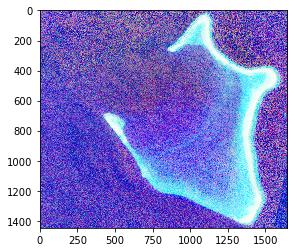

In [2]:
ImagesFolder = '../../Images/Acolite/S2A_MSIL1C_20170929T231851_N0205_R001_T58KDE_20170929T231932/'
raster_wavelength = ['443','492','560','665', '704']
raster_Name = ['Deglint/' + f + '.tif' for f in raster_wavelength]
bands_data = []

for f in range(len(raster_Name)):
    raster_dataset = gdal.Open(ImagesFolder+raster_Name[f], gdal.GA_ReadOnly)
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())

for i in range(len(bands_data)):
    print(bands_data[i].shape)
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
print(bands_data.shape)


raster_dataset = gdal.Open(ImagesFolder+raster_Name[2], gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()

plt.imshow(exposure.equalize_hist(bands_data[:,:,np.array([3,2,1])]))

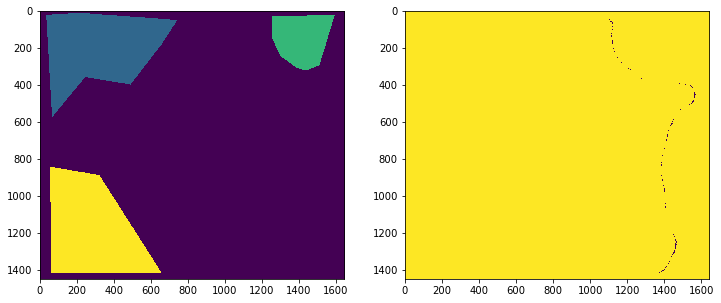

In [3]:
ShapeFolder = '../../Shapes/'
SoilIndex = 'Mask/SoilMask.tif'
Lagoon = 'Mask/Lagoon.tif'
DeepIndex = 'Deeps.shp'

DeepIndex = mgp.create_mask_from_vector(ShapeFolder + DeepIndex, cols, rows, geo_transform, proj, target_value=1, format=gdal.GDT_Byte)
DeepIndex = DeepIndex.GetRasterBand(1).ReadAsArray().astype(bool)
labeled_DeepSamples = label(DeepIndex)

SoilIndex = gdal.Open(ImagesFolder + SoilIndex, gdal.GA_ReadOnly)
SoilIndex =SoilIndex.GetRasterBand(1).ReadAsArray().astype(bool)

ClassifyIndex = ~SoilIndex 
mgp.write_raster2(ImagesFolder + Lagoon, ClassifyIndex, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_Byte )

ClassifyIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifyIndex = ClassifyIndex.GetRasterBand(1).ReadAsArray().astype(bool)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(labeled_DeepSamples)
ax[1].imshow(ClassifyIndex)


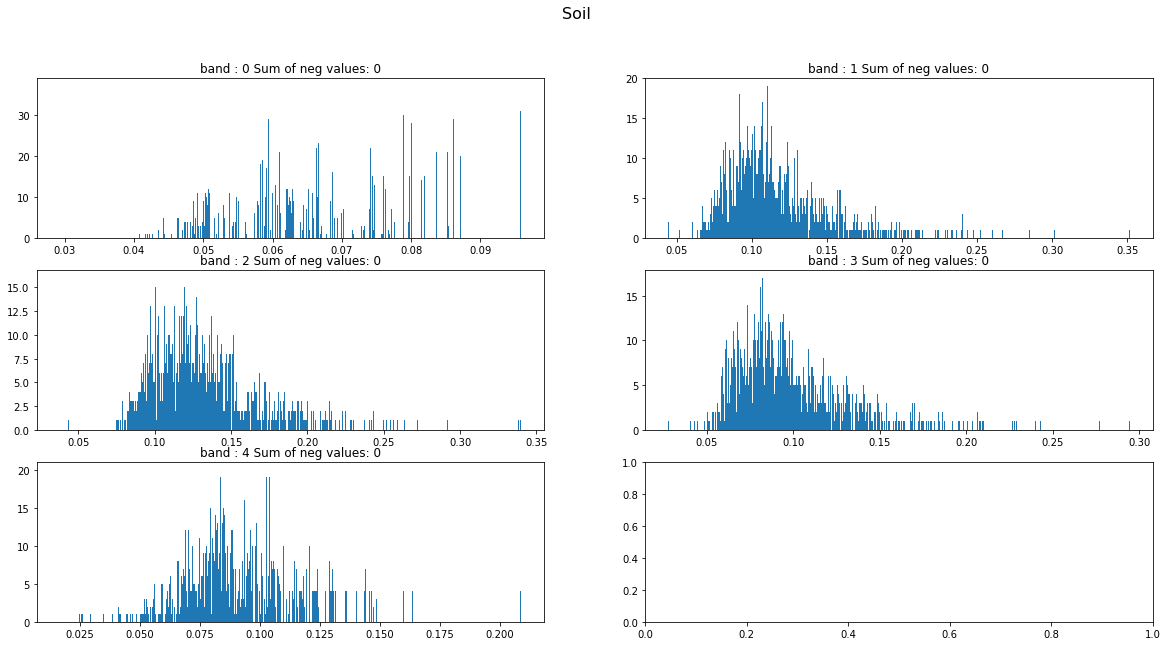

In [4]:

fig , axes = plt.subplots(3,2, figsize=(20,10))
plt.suptitle('Soil', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i>4:
        break
    ax.set_title('band : '+str(i)+' Sum of neg values: '+ str(np.sum(bands_data[SoilIndex,i].ravel()<0)))
    ax.hist(bands_data[SoilIndex,i].ravel(), bins=1000)
    

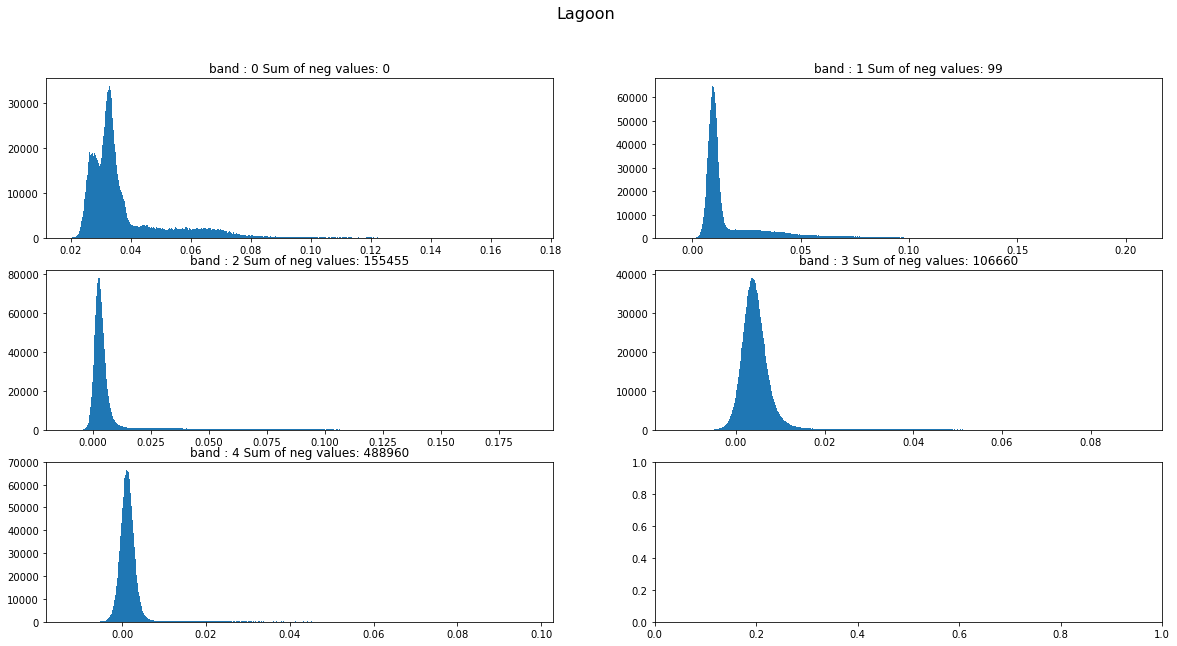

In [5]:
fig , axes = plt.subplots(3,2, figsize=(20,10))
plt.suptitle('Lagoon', fontsize=16)
for i, ax in enumerate(fig.axes):
    if i>4:
        break
    ax.set_title('band : '+str(i)+' Sum of neg values: '+ str(np.sum(bands_data[ClassifyIndex,i].ravel()<0)))
    ax.hist(bands_data[ClassifyIndex,i].ravel(), bins=1000)

In [6]:
for i in range(5):
    print('Minimum value in band ',i,': ',np.min(bands_data[ClassifyIndex,i]))
    print('Number initial nan value in band ',i,': ',np.sum(np.isnan(bands_data[ClassifyIndex,i])))
    FalseIndex = bands_data[:,:,i]<0
    bands_data[np.logical_and(FalseIndex,ClassifyIndex),i] = np.nan
    print("="*10)

Minimum value in band  0 :  0.0194435
Number initial nan value in band  0 :  0
Minimum value in band  1 :  -0.00669236
Number initial nan value in band  1 :  0
Minimum value in band  2 :  -0.0103003
Number initial nan value in band  2 :  0
Minimum value in band  3 :  -0.0130937
Number initial nan value in band  3 :  0
Minimum value in band  4 :  -0.0126444
Number initial nan value in band  4 :  0


# Warning: Checking for multiplicator n

In [7]:
n = 1000.0
if not n > np.max([1.0/np.nanmin(bands_data[ClassifyIndex,i]) for i in range(bands_data.shape[2])]):
    n = 100.0 + np.max([1.0/np.nanmin(bands_data[ClassifyIndex,i]) for i in range(bands_data.shape[2])])

LagoonData = np.full(bands_data.shape, np.nan, np.float)
LagoonData[ClassifyIndex,:] = bands_data[ClassifyIndex,:]
del bands_data

LagoonData[ClassifyIndex,:] = np.log(n * LagoonData[ClassifyIndex,:])

In [8]:
Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
count=1

data = {}
for i in range(LagoonData.shape[2]-1,-1,-1): 
    for i2 in range(i-1,-1,-1):
        data[Band[i2], Band[i]] = count
        count = count +1
data

{('Blue', 'ExtraRed'): 3,
 ('Blue', 'Green'): 8,
 ('Blue', 'Red'): 6,
 ('ExtraBlue', 'Blue'): 10,
 ('ExtraBlue', 'ExtraRed'): 4,
 ('ExtraBlue', 'Green'): 9,
 ('ExtraBlue', 'Red'): 7,
 ('Green', 'ExtraRed'): 2,
 ('Green', 'Red'): 5,
 ('Red', 'ExtraRed'): 1}

In [9]:
Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
count=1

data = {}
for i in range(LagoonData.shape[2]-1,-1,-1): 
    for i2 in range(i-1,-1,-1):
        data[Band[i2], Band[i]] = np.divide(LagoonData[:,:,i2], LagoonData[:,:,i])
        count = count +1

In [10]:
for i in data.keys():
    print('Band :',i)
    print('Number of equality value: ',np.sum(data[i][ClassifyIndex]==1.000))
    print('Number of NaN value: ',np.sum(np.isnan(data[i][ClassifyIndex])))
    print('Interval of value: ',np.nanmax(data[i][ClassifyIndex]) - np.nanmin(data[i][ClassifyIndex]))
    print("="*10)

Band : ('Red', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  571672
Interval of value:  184961098.268
Band : ('Green', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  606415
Interval of value:  178009720.843
Band : ('Blue', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  489035
Interval of value:  194456275.479
Band : ('ExtraBlue', 'ExtraRed')
Number of equality value:  0
Number of NaN value:  488960
Interval of value:  208703341.921
Band : ('Green', 'Red')
Number of equality value:  0
Number of NaN value:  228658
Interval of value:  5.30111315296
Band : ('Blue', 'Red')
Number of equality value:  0
Number of NaN value:  106741
Interval of value:  5.0593737355
Band : ('ExtraBlue', 'Red')
Number of equality value:  0
Number of NaN value:  106660
Interval of value:  5.11436660921
Band : ('Blue', 'Green')
Number of equality value:  0
Number of NaN value:  155528
Interval of value:  14.6968659585
Band : ('ExtraBlue', 'Green')
Number of equality

In [11]:
RX = []
for i in data.keys():
    RX.append(data[i])
RecordOrdered_Keys = data.keys()
del data
SRX = np.stack(RX,axis=2)
del RX

In [12]:
np.savez_compressed('../../CompressedData/SRXData', Ratios=SRX, FocusIndex=np.full((rows, cols),True), Keys=[k for k in RecordOrdered_Keys], ClassifyIndex=ClassifyIndex, Multiplicator=n, mode='LowlyAt/HighlyAt')